# Pair Trading with Johansen Cointegration

This notebook demonstrates a pairs-trading strategy using the Johansen test:
- Generate two (cointegrated) price series  
- Test for cointegration (Johansen)  
- Extract cointegration vector & compute spread & z-score  
- Generate entry/exit signals  
- Simulate P&L  
- Plot prices, spread/z-score, and cumulative P&L

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# For reproducibility
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Generate Synthetic Price Series
We create:
- `S1` as a random walk  
- `S2` as a linear function of `S1` plus small noise (to induce cointegration)

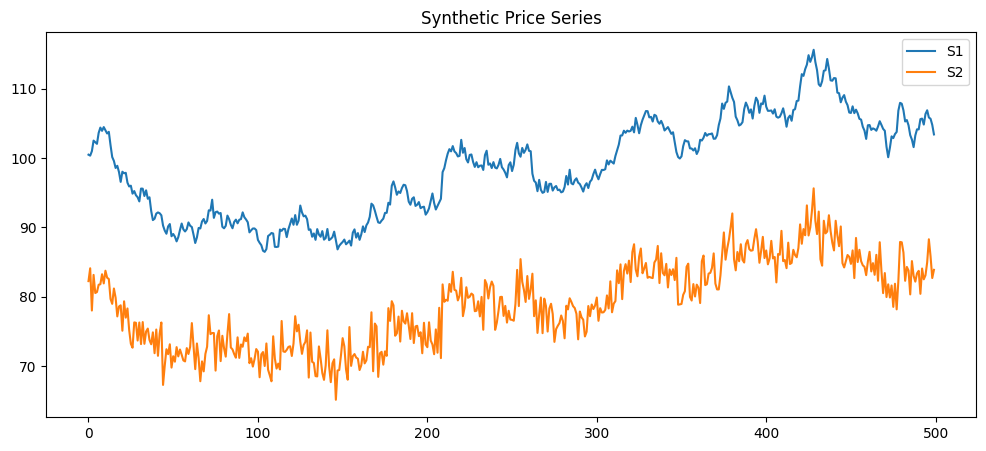

In [2]:
n = 500
t = np.arange(n)

# Random walk for S1
eps1 = np.random.normal(scale=1.0, size=n)
S1 = 100 + np.cumsum(eps1)

# S2 = 0.8 * S1 + noise
beta_true = 0.8
eps2 = np.random.normal(scale=2.0, size=n)
S2 = beta_true * S1 + eps2

# Put into DataFrame
df = pd.DataFrame({'S1': S1, 'S2': S2})
df.plot(title="Synthetic Price Series")
plt.show()

## 2. Johansen Cointegration Test
We test for the presence of one cointegration relation between `S1` and `S2`.

In [3]:
# Johansen test (no deterministic trend, lag diff 1)
jres = coint_johansen(df[['S1', 'S2']], det_order=0, k_ar_diff=1)
print("Trace Statistics:", jres.lr1)
print("Critical Values (90%, 95%, 99%):\n", jres.cvt)

# Extract the first cointegration vector
evec = jres.evec[:, 0]
print("Cointegration vector:", evec)

Trace Statistics: [203.78110546   2.21924144]
Critical Values (90%, 95%, 99%):
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Cointegration vector: [ 0.59471004 -0.73038656]


## 3. Compute Spread & Z-Score
The spread is the linear combination:
\[ \text{spread}_t = evec[0] \times S1_t + evec[1] \times S2_t \]
We then compute its z-score.

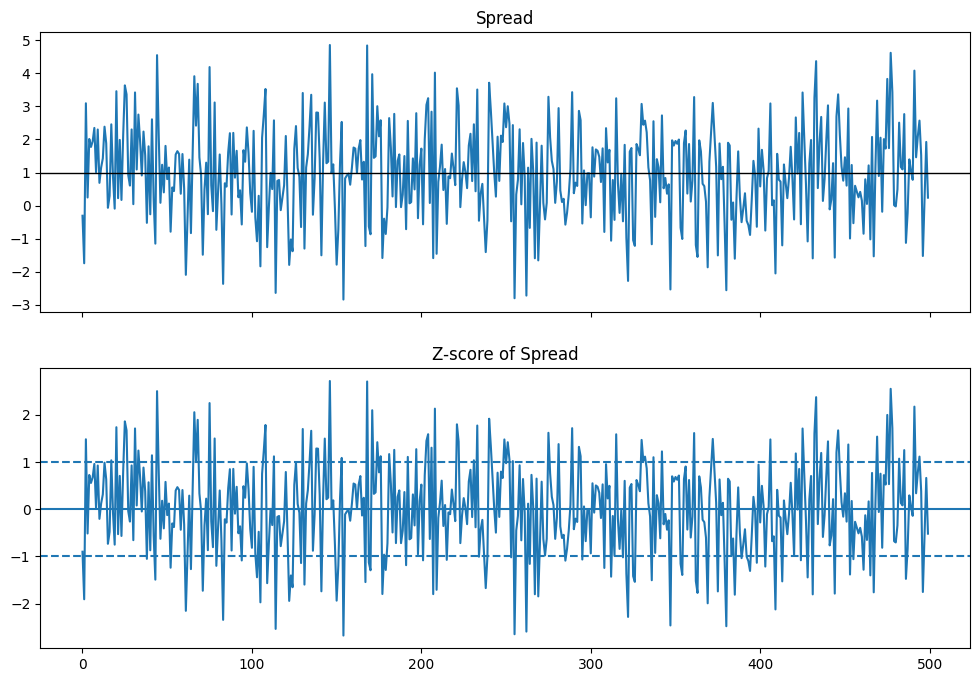

In [4]:
df['spread'] = evec[0] * df['S1'] + evec[1] * df['S2']
df['zscore'] = (df['spread'] - df['spread'].mean()) / df['spread'].std()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))
df['spread'].plot(ax=axes[0], title='Spread')
axes[0].axhline(df['spread'].mean(), color='black', lw=1)
df['zscore'].plot(ax=axes[1], title='Z-score of Spread')
axes[1].axhline( 1.0, linestyle='--')
axes[1].axhline(-1.0, linestyle='--')
axes[1].axhline( 0.0, linestyle='-')
plt.show()

## 4. Generate Trading Signals
- **Enter long spread** when z < –1  (long spread)  
- **Enter short spread** when z > +1 (short spread)  
- **Exit** when |z| < 0

In [5]:
entry_z, exit_z = 1.0, 0.0

df['long_spread']  = (df['zscore'] < -entry_z).astype(int)
df['short_spread'] = (df['zscore'] >  entry_z).astype(int)

# Position: +1 long spread, -1 short spread, 0 flat
df['position'] = 0
pos = 0
for i in range(len(df)):
    if pos == 0:
        if df['long_spread'].iloc[i]: pos = +1
        elif df['short_spread'].iloc[i]: pos = -1
    elif pos == +1 and abs(df['zscore'].iloc[i]) < exit_z:
        pos = 0
    elif pos == -1 and abs(df['zscore'].iloc[i]) < exit_z:
        pos = 0
    df.at[df.index[i], 'position'] = pos

df['position'].value_counts().sort_index()

position
0      1
1    499
Name: count, dtype: int64

## 5. Simulate P&L
Calculate daily P&L and cumulative P&L.

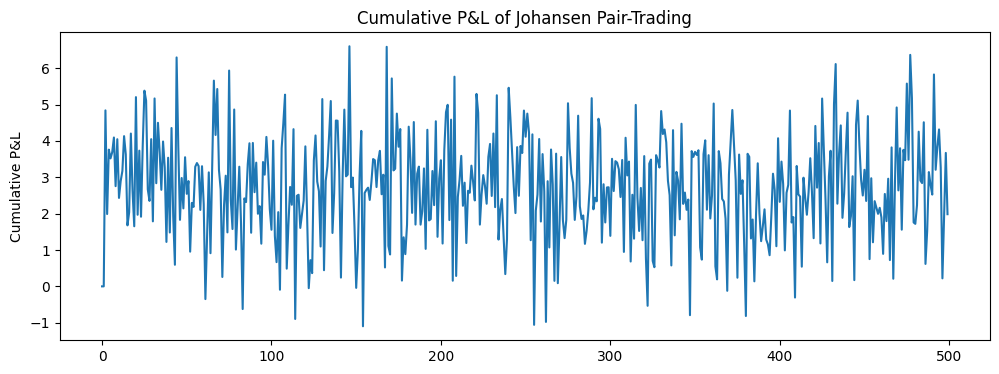

In [6]:
df['spread_diff'] = df['spread'].diff()
df['pnl'] = df['position'].shift(1) * df['spread_diff']
df['cum_pnl'] = df['pnl'].cumsum().fillna(0)

plt.figure(figsize=(12,4))
df['cum_pnl'].plot(title='Cumulative P&L of Johansen Pair-Trading')
plt.ylabel('Cumulative P&L')
plt.show()

### Summary
- **Trace statistics** vs critical values indicate cointegration rank.  
- **Cointegration vector** from Johansen test provides hedge ratios.  
- **Strategy P&L** based on that vector.